# Project Planning Stage

In [1]:
library(tidyverse)
library(lubridate)
library(scales)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




## (1) Data Description

The Pacific Laboratory for Artificial Intelligence (PLAI), to advance embodied AI research, has set up a Minecraft server named PLAICRAFT to collect behavioural data on volunteer players. A portion of the data from PLAI's endeavours has been provided for this project. The provided data consists of two datasets: `players.csv` and `session.csv`. The details of each data set are below. See section 3 for the calculation of summary values reported here:

### (1.1) players.csv
This dataset contains the following 7 variables regarding 196 players from the server: 
|**Variable**|**Read Data Type**|**Proper Data Type**|**Description**|
|:-:|:-:|:-:|:-|
|experience|`chr`|`fct`|Self-evaluated Minecraft experience level. One of: *Beginner*, *Amateur*, *Regular*, *Pro* or *Veteran*|
|subscribe|`lgl`|`lgl`|Whether player is subscribed to a game-related newsletter. 144 are subscribed, 52 are not.|
|hashedEmail|`chr`|`chr`|Encrypted email|
|played_hours|`dbl`|`dbl`|Hours played on the server. mean = 5.8h, min = 0h, max = 223.1|
|name|`chr`|`chr`|Player's auto-generated genric name|
|gender|`chr`|`fct`| One of: *Male*, *Female*, *Non-binary*, *Agender*, *Two-spirited*, *Other* or *Perfer not to say*|
|Age|`dbl`|`int`|Self-reported age. Players must be at least 7. The age selector had a maximum age of 99 and a default of 17. mean = 20.5, min = 8, max = 50|

**Potential issues:** 
- `subscribe` will need balancing for KNN classification.
- There are an inordinate number of 17-year-olds (see section 3.7) due to 17 being the default age on the given survey.
- The small sample size increases the effects of random unaccountable fluctuations in data.

### (1.2) sessions.csv
This dataset contains the following 5 variables regarding 1535 distinct play sessions of various players from the server:
|**Variable**|**Read Data Type**|**Proper Data Type**|**Description**|
|:-:|:-:|:-:|:-|
|hashedEmail|`chr`|`chr`|Encrypted email|
|start_time|`chr`|`dttm`|Start time of session (dd/mm/yyyy hh/mm)|
|end_time|`chr`|`dttm`|End time of session (dd/mm/yyyy hh/mm)|
|original_start_time|`dbl`|`dbl`|Start time of session in UNIX format|
|original_end_time|`dbl`|`dbl`|End time of session in UNIX format|

**Potential Issues:** 
- `original_start_time` and `original_end_time` are in scientific notation when they should be a simple string of numbers, this renders them useless.

## (2) Questions

**Broad question**: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific question**: Can the self-reported age, self-reported experience level, and the total hours played by a given player predict whether that player will be subscribed to receive a game-related newsletter as determined with players in the PLAICRAFT Minecraft server?

The `players.csv` dataset will be used. The `Age`, `experience`, `played_hours` and `subscribe` variables will be isolated. The experience levels *Beginner*, *Amateur*, *Regular*, *Pro* and *Veteran* will be recoded as integers 1-5 respectively. `Age`, `experience` and `played_hours` will then be selectively used to predict `subscribe`.

## (3) Exploratory Data Analysis and Visualization

### (3.1) Reading `players.csv`:

In [2]:
players_url <- "https://raw.githubusercontent.com/mke-l/dsci100-project-data/refs/heads/main/players.csv"
players <- read_csv(players_url)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### (3.2) Reading `sessions.csv`:

In [3]:
sessions_url <- "https://raw.githubusercontent.com/mke-l/dsci100-project-data/refs/heads/main/sessions.csv"
sessions <- read_csv(sessions_url)
head(sessions)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


### (3.3) Conversion of `players.csv` variables to proper data type, tidying of variable names, reordering of experience factor:

In [4]:
players_tidy <- players |>
    mutate(experience = as_factor(experience)) |>
    rename(hashed_email = hashedEmail) |>
    mutate(gender = as_factor(gender)) |>
    rename(age = Age) |>
    mutate(age = as.integer(age)) |>
    mutate(experience = fct_relevel(experience, "Beginner", "Amateur", "Regular", "Pro", "Veteran"))

head(players_tidy)

experience,subscribe,hashed_email,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### (3.4) Conversion of `sessions.csv` variables to proper data type, tidying of variable names. 

**Note:** The `sessions.csv` date frame will not be investigated further after this as it is irrelevant to the variables within the research question:

In [5]:
sessions_tidy <- sessions |>
    mutate(start_time = dmy_hm(start_time)) |>
    mutate(end_time = dmy_hm(end_time)) |>
    rename(hashed_email = hashedEmail)

head(sessions_tidy)

hashed_email,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,1.71916e+12,1.71916e+12


### (3.5) Computing mean, min and max values of all `players.csv` quantitative variables:

In [17]:
players_stats <- players_tidy |>
    select(played_hours, age) |>
    summarize(mean_played_hours = mean(played_hours),
             min_played_hours = min(played_hours),
             max_played_hours = max(played_hours),
             mean_age = mean(age, na.rm = TRUE),
             min_age = min(age, na.rm = TRUE),
             max_age = max(age, na.rm = TRUE))

players_stats

mean_played_hours,min_played_hours,max_played_hours,mean_age,min_age,max_age
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
5.845918,0,223.1,20.52062,8,50


### (3.6) Distribution of players subscribed and not subscribed to the newsletter:

In [18]:
players_tidy |>
    group_by(subscribed_to_newsletter = subscribe) |>
    summarize(count = n())

subscribed_to_newsletter,count
<lgl>,<int>
FALSE,52
TRUE,144


This shows an considerable imbalence in the responding variable, this will need to be balenced.

### (3.7) Distribution of players by age:

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


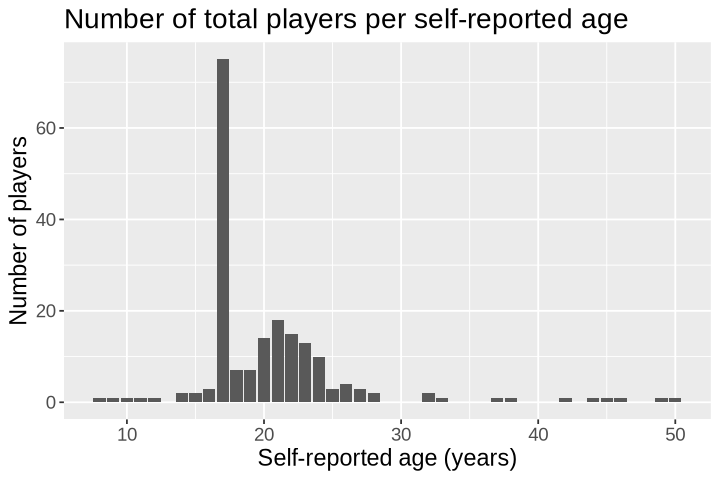

In [19]:
options(repr.plot.width = 6, repr.plot.height = 4)

ggplot(players_tidy, aes(x = age)) +
    geom_bar(stat = "count") +
    labs(title = "Number of total players per self-reported age",
        x = "Self-reported age (years)",
        y = "Number of players") +
    theme(text = element_text(size = 14))

This shows that the general non-extreme data clusters around a median of 21 years with there also being an extreme spike at 17 years. This is explained since 17 is the default value for the age question on the data collection survey.

### (3.8) Fraction of players subscribed to the newsletter per experience level:

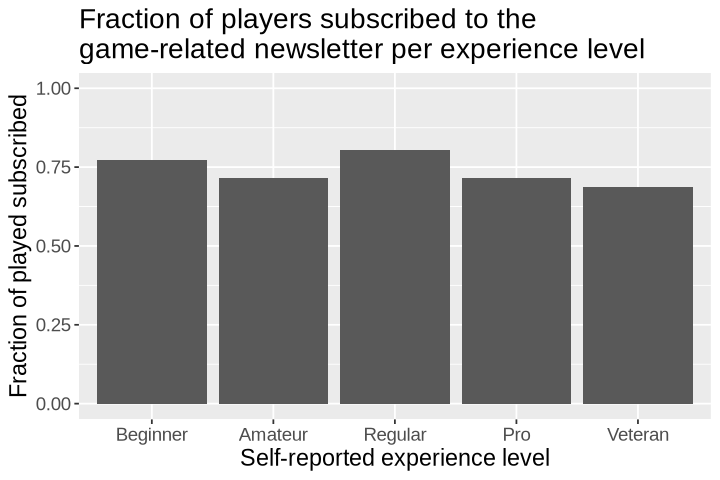

In [20]:
players_experience_count <- players_tidy |>
    group_by(experience) |>
    summarize(total = n())

players_subscribed_experiance_count <- players_tidy |>
    filter(subscribe) |>
    group_by(experience) |>
    summarize(subscribed = n())

players_experience_subscribed_fraction <- players_experience_count |>
    bind_cols(subscribed = pull(players_subscribed_experiance_count, subscribed)) |>
    mutate(fraction = subscribed/total)


ggplot(players_experience_subscribed_fraction, aes(x = experience, y = fraction)) +
    geom_bar(stat = "identity") +
    ylim(c(0, 1)) +
    labs(title = "Fraction of players subscribed to the \ngame-related newsletter per experience level",
        x = "Self-reported experience level",
        y = "Fraction of played subscribed") +
    theme(text = element_text(size = 14))

There is a general downwards trend in subscriptions as experience increases with the exception of players of *Regular* experience. This shows experience may be a useful predictor of subscription.

### (3.9) Total play time and the age of various players colored according to subscription status:

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


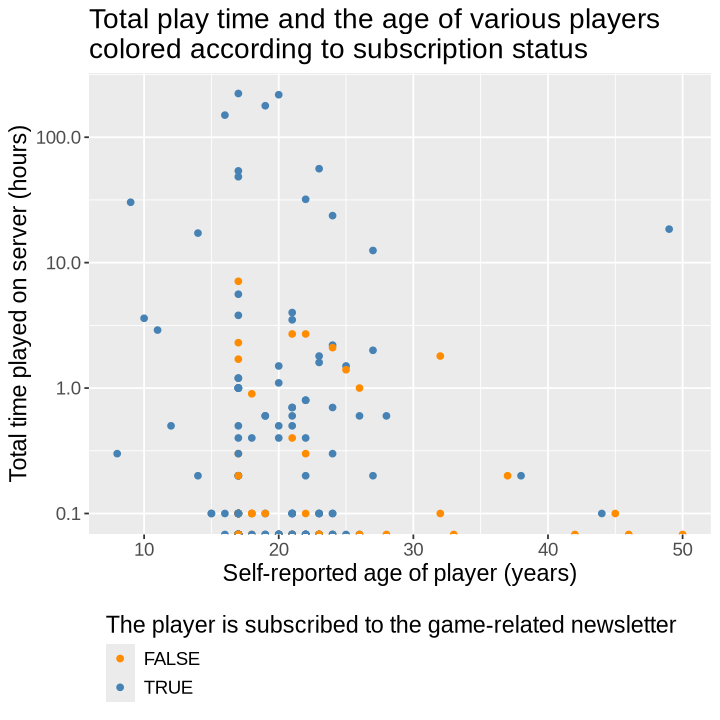

In [21]:
options(repr.plot.width = 6, repr.plot.height = 6)

ggplot(players_tidy, aes(x = age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(title = "Total play time and the age of various players \ncolored according to subscription status",
        x = "Self-reported age of player (years)",
        y = "Total time played on server (hours)",
        color = "The player is subscribed to the game-related newsletter") +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    scale_y_log10() +
    theme(text = element_text(size = 14),
         legend.position = "bottom",
         legend.direction = "vertical")

It is seen generally that players of higher playtime and lesser age are more likely to be subscribed to a game-related newsletter. Though the relationship is highly mixed, these two variables could both prove useful in predicting subscription.

## (4) Methods and Plan

After the data wrangling described in Section 2, the data will be balanced over the `subscribe` variable and then split into 75% training and 25% testing data. With the training data, best subset selection will determine which of `age`, `experience` and `played_hours` will be included in a KNN classification model to predict `subscribe`. 5-fold cross-validation will determine the optimal value for K. Finally, the resulting prediction model will be assessed with the test data.

The response variable is a Boolean variable, making it suitable for classification. Best subset selection and cross-validation will ensure optimization of KNN classification. It is assumed that the bias in the age predictor for 17 will not have too great an effect on predictions. This model is limited in that no predictor correlated strongly with the label, but they are the best choices available.